# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- matplotlib 3.5.2

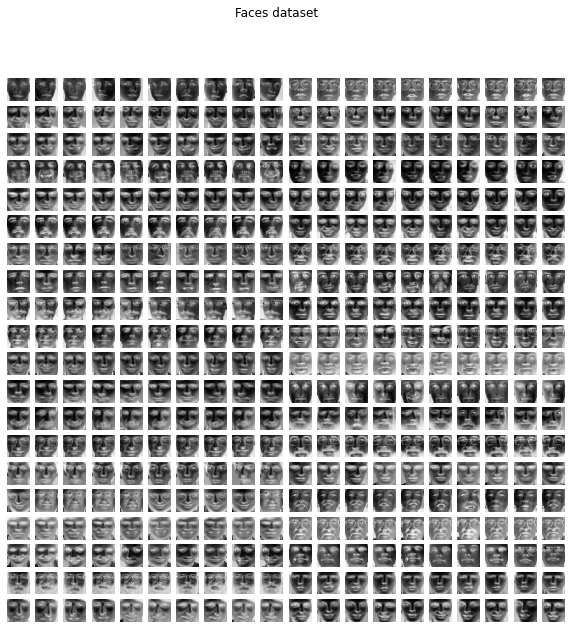

In [1]:
from sklearn import datasets, mixture
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
X = faces.data

fig, axs = plt.subplots(nrows=20, ncols=20, figsize=(10, 10))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((64, 64)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Faces dataset", fontsize=12)


## Actividad en clase

Usando el algoritmo **GMM**, haga lo siguiente:

- Reduzca la dimensionalidad del dataset usando **PCA** para retener el 99% de la varianza de X.
- Calcule la curva **AIC** para n en {1,50} en intervalos de 1 y seleccione el número de componentes de la mezcla.
- Ajuste **GMM** usando el número de componentes seleccionado en el paso anterior.
- Genere 100 muestras usando **GMM**.
- Dibuje los datos generados por el modelo en un arreglo de 10 x 10.
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que cada L es una décima más en la nota de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

In [2]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
X = pca.fit_transform(X)
X.shape

(400, 260)

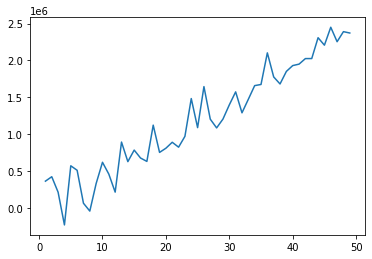

In [3]:
import numpy as np

n_components = np.arange(1, 50, 1)
models = [mixture.GaussianMixture(n, covariance_type='full') for n in n_components]
aics = [model.fit(X).aic(X) for model in models]
plt.plot(n_components, aics);

In [4]:
gmm = mixture.GaussianMixture(5, covariance_type='full')
gmm.fit(X)
print(gmm.converged_)

True


In [5]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 260)

In [6]:
synthetic_data = pca.inverse_transform(data_new[0])

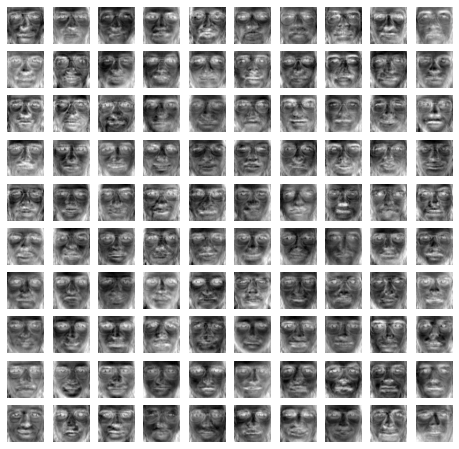

In [7]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(synthetic_data[idx].reshape((64, 64)), cmap=plt.cm.binary)
    ax.axis("off")